## Predicting 2023 MLB Season: 02 - Building Initial Model
- In this notebook, I further explore the data from 01, and build/evaluate the first iteration of a model.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [3]:
df=pd.read_csv('./output_data/input_model_data_01.csv')

C:\Users\Dylan McGee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (13,15,85,87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Checks / Exploration

In [4]:
df.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56775 entries, 0 to 56774
Data columns (total 202 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    date                  56775 non-null  int64  
 1    dblheader_code        56775 non-null  int64  
 2    day_of_week           56775 non-null  object 
 3    team_v                56775 non-null  object 
 4    league_v              56775 non-null  object 
 5    game_no_v             56775 non-null  int64  
 6    team_h                56775 non-null  object 
 7    league_h              56775 non-null  object 
 8    game_no_h             56775 non-null  int64  
 9    runs_v                56775 non-null  int64  
 10   runs_h                56775 non-null  int64  
 11   outs_total            56775 non-null  int64  
 12   day_night             56775 non-null  object 
 13   completion_info       49 non-null     object 
 14   forfeit_info          0 non-null      float64
 15   

In [5]:
# How many games per season?
df.season.value_counts().sort_index()

2000    2429
2001    2429
2002    2426
2003    2430
2004    2428
2005    2431
2006    2429
2007    2431
2008    2428
2009    2430
2010    2430
2011    2429
2012    2430
2013    2431
2014    2430
2015    2429
2016    2428
2017    2430
2018    2431
2019    2429
2020     898
2021    2429
2022    2430
2023    2430
Name: season, dtype: int64

In [6]:
# Average W% of home team
hv_mean = df.home_victory.mean()
hv_mean

0.5380713342140027

In [7]:
# Most popular run differentials
df.run_diff.value_counts()

 1     9712
-1     6331
 2     5306
-2     4979
 3     4198
-3     3961
 4     3343
-4     3248
 5     2388
-5     2379
 6     1768
-6     1677
-7     1240
 7     1233
 8      901
-8      803
 9      625
-9      602
 10     409
-10     360
 11     250
-11     229
 12     152
-12     138
-13     125
 13     112
-14      59
 14      59
 15      39
-15      33
-16      22
 16      21
 17      11
-17      10
-18      10
 18       7
 21       6
 19       6
 0        6
-19       5
-21       3
-20       2
 20       2
 22       1
-22       1
-27       1
-23       1
-24       1
Name: run_diff, dtype: int64

In [8]:
# Count by outs in a given game
df.outs_total.value_counts()

51     25871
54     23723
60      1124
53      1037
52       932
66       592
58       515
59       452
72       296
57       289
64       233
65       221
63       143
78       138
70       132
42       109
39       108
71        99
84        87
77        73
76        64
69        63
75        44
82        41
83        35
90        35
96        25
48        21
36        20
89        20
30        19
45        17
81        15
88        13
41        12
33        11
108       11
102        9
94         9
40         8
46         8
31         8
95         7
87         6
93         6
106        6
27         5
38         5
37         5
44         5
47         4
111        4
100        3
114        3
113        3
32         3
101        3
107        3
120        3
34         3
43         3
28         3
112        2
29         2
105        2
50         1
132        1
99         1
55         1
Name: outs_total, dtype: int64

In [9]:
# Outlier: 53 outs in a game should always signal a win for the home team, right?
df.home_victory[df.outs_total==53].mean()

0.9990356798457087

In [10]:
# Finding the annomaly - looks like there was a rainout in the bottom of the 9th inning
df.loc[(df.outs_total==53) & (df.home_victory!=1),:]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OPS_162_h,OPS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,SO_perc_162_h,SO_perc_162_v,BB_perc_162_h,BB_perc_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OPS_30_h,OPS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,SO_perc_30_h,SO_perc_30_v,BB_perc_30_h,BB_perc_30_v
14327,20050915,0,Thu,SLN,NL,148,CHN,NL,147,6,1,53,N,NaN,NaN,NaN,CHI11,37849.0,167,300000030,000000001,33,9,1,0,0,5,0,1,0,5,0,6,0,1,1,0,6,2,1,1,1,0,26,12,1,0,1,0,33,8,0,0,1,1,0,0,0,2,0,8,0,0,1,0,8,3,5,5,0,0,27,13,1,0,2,0,wolfj901,Jim Wolf,holbs901,Sam Holbrook,vanol901,Larry Vanover,marsr901,Randy Marsh,NaN,(none),NaN,(none),larut101,Tony LaRussa,baked002,Dusty Baker,suppj001,Jeff Suppan,priom001,Mark Prior,NaN,(none),walkl001,Larry Walker,suppj001,Jeff Suppan,priom001,Mark Prior,ecksd001,David Eckstein,6,edmoj001,Jim Edmonds,8,pujoa001,Albert Pujols,3,walkl001,Larry Walker,9,rodrj002,John Rodriguez,7,nunea001,Abraham Nunez,5,moliy001,Yadier Molina,2,lunah001,Hector Luna,4,suppj001,Jeff Suppan,1,hairj002,Jerry Hairston,8,walkt002,Todd Walker,4,lee-d002,Derrek Lee,3,garcn001,Nomar Garciaparra,5,burnj001,Jeromy Burnitz,9,murtm001,Matt Murton,7,peren001,Neifi Perez,6,blanh001,Henry Blanco,2,priom001,Mark Prior,1,NaN,Y,2005,-5,0,7,200509150,0.268813,0.270416,0.323345,0.334703,0.439957,0.424193,0.763303,0.758897,63.0,88.0,36.0,37.0,98.0,99.0,0.164561,0.177754,0.080591,0.096629,0.271073,0.263467,0.322351,0.32737,0.444444,0.39569,0.766795,0.723061,12.0,20.0,6.0,5.0,15.0,23.0,0.154215,0.201763,0.07567,0.095005


In [11]:
# Outlier - there were 8 games played over the standard 162 game season. Most from weather reschedules
df.game_no_h.value_counts().sort_index()

1      359
2      359
3      364
4      357
5      358
6      361
7      369
8      363
9      362
10     356
11     357
12     348
13     354
14     353
15     362
16     366
17     363
18     359
19     385
20     372
21     355
22     356
23     362
24     350
25     346
26     352
27     355
28     364
29     359
30     361
31     368
32     373
33     363
34     354
35     363
36     353
37     351
38     345
39     354
40     366
41     377
42     366
43     362
44     374
45     373
46     368
47     355
48     353
49     353
50     349
51     332
52     349
53     353
54     367
55     372
56     360
57     369
58     366
59     366
60     361
61     342
62     345
63     347
64     342
65     346
66     359
67     353
68     340
69     340
70     330
71     336
72     338
73     340
74     347
75     347
76     361
77     352
78     346
79     350
80     348
81     353
82     347
83     327
84     342
85     347
86     358
87     342
88     335
89     338
90     338
91     347

## Begin Modeling - LightGBM

In [12]:
# Remove games ending in a tie. We want win or loss only
df = df[df.run_diff!=0] 
df_train = df[(df.season>=2000) & (df.season<=2020)]
df_valid = df[(df.season>=2021) & (df.season<=2022)]
df_test = df[df.season>=2023]

In [13]:
# Independent variables
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'OPS_162_h','OPS_162_v',
            'SO_perc_162_h','SO_perc_162_v',
            'BB_perc_162_h','BB_perc_162_v'
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
# Dependent variable
target = 'home_victory'

In [14]:
# Create train, validation, and test sets w/ columns noted above
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [15]:
X_train.shape, X_valid.shape, X_test.shape

((49480, 10), (4859, 10), (2430, 10))

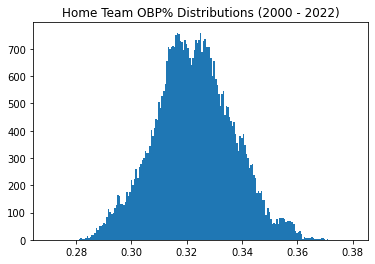

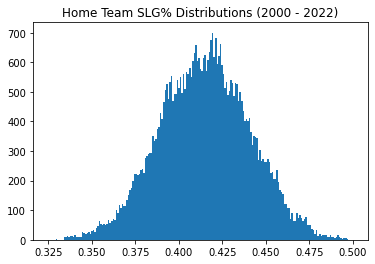

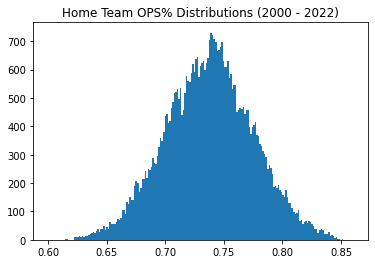

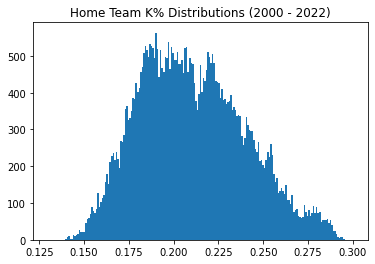

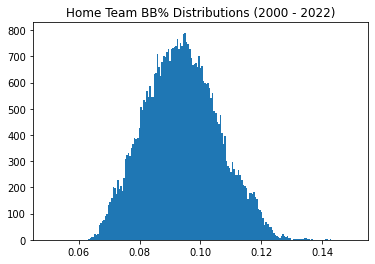

In [16]:
plt.hist(X_train.OBP_162_h, np.linspace(.27,.38,200));
# plt.hist(X_train.OBP_162_v, np.linspace(.26,.38,151));
plt.title('Home Team OBP% Distributions (2000 - 2022)')
plt.show()

plt.hist(X_train.SLG_162_h, np.linspace(.325,.5,200));
plt.title('Home Team SLG% Distributions (2000 - 2022)')
plt.show()

plt.hist(X_train.OPS_162_h, np.linspace(.6,.86,200));
plt.title('Home Team OPS% Distributions (2000 - 2022)')
plt.show()

plt.hist(X_train.SO_perc_162_h, np.linspace(.13,.3,200));
plt.title('Home Team K% Distributions (2000 - 2022)')
plt.show()

plt.hist(X_train.BB_perc_162_h, np.linspace(.05,.15,200));
plt.title('Home Team BB% Distributions (2000 - 2022)')
plt.show()

In [28]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)]) # Early stopping will stop execution if losloss doesnt decrease after X consectuive rounds on the validation set

[LightGBM] [Info] Number of positive: 26678, number of negative: 22802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 49480, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539167 -> initscore=0.156991
[LightGBM] [Info] Start training from score 0.156991
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689321
[20]	valid_0's binary_logloss: 0.688114
[30]	valid_0's binary_logloss: 0.687201
[40]	valid_0's binary_logloss: 0.686434
[50]	valid_0's binary_logloss: 0.685721
[60]	valid_0's binary_logloss: 0.685126
[70]	valid_0's binary_logloss: 0.6847
[80]	valid_0's binary_logloss: 0.68413
[90]	valid_0's binary_logloss: 0.683709
[100]	valid_0's binary_logloss: 0.683404
[110]	valid_0's binary_logloss: 0.683065
[120]	va

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [29]:
# Get probabilities of home victory
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

# Compare the naive prediction: model's performance vs. taking the mean w% against every game 
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

# NOTE: Looks like our model is performing slightly better than taking the naive prediction

(0.6853173597180855, 0.6928521592184054)

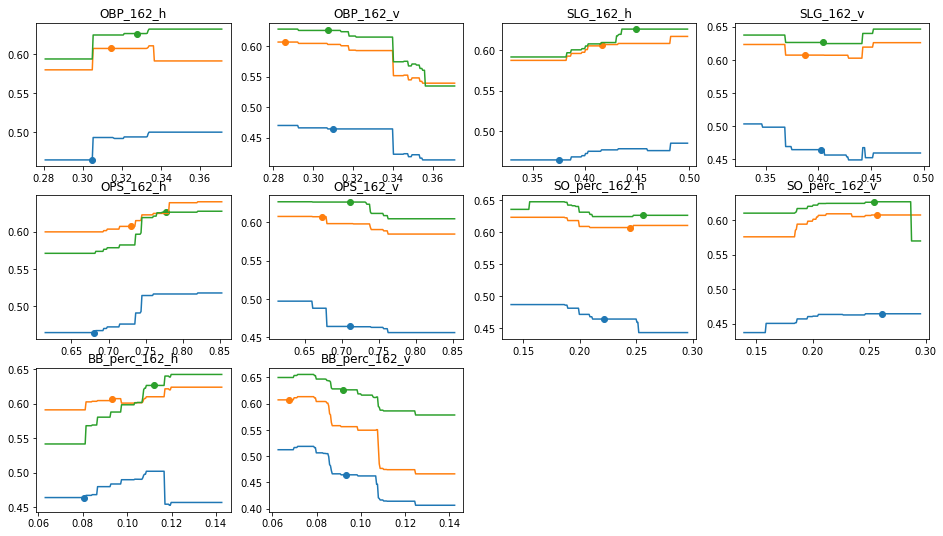

In [30]:
# Create ice plot to compare metric with win %
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=4)

- For the home team, we should expect that as stats like OBP, SLG, OPS increases (X axis) win percentage should also increase (Y axis).
- For the away team, we should expect as these same metrics increase, the W% should decrease for home team

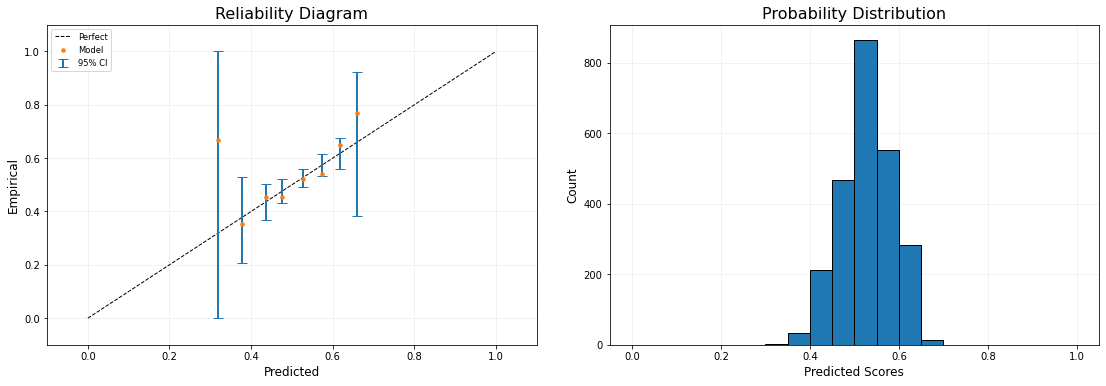

In [22]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

# Trying Different Model - StructureBoost

In [31]:
fc = stb.get_basic_config(X_train, stb.default_config_dict())

stb1 = stb.StructureBoost(max_depth=3, learning_rate=.02, feature_configs = fc, num_trees=2000)
stb1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5)

i=0, eval_set_loss = 0.6905545076335289
i=10, eval_set_loss = 0.6886918709170915
i=20, eval_set_loss = 0.6871500094278156
i=30, eval_set_loss = 0.6860306799255459
i=40, eval_set_loss = 0.6852932552627118
i=50, eval_set_loss = 0.6845364276114411
i=60, eval_set_loss = 0.6838429284733893
i=70, eval_set_loss = 0.6834147840811076
i=80, eval_set_loss = 0.6829265523461598
i=90, eval_set_loss = 0.682602984706982
i=100, eval_set_loss = 0.6823202036127692
i=110, eval_set_loss = 0.682171894901237
i=120, eval_set_loss = 0.6820771347935662
i=130, eval_set_loss = 0.6819582505274278
i=140, eval_set_loss = 0.6818057396607491
i=150, eval_set_loss = 0.681644337911957
i=160, eval_set_loss = 0.6815924051178701
i=170, eval_set_loss = 0.6814927644241101
i=180, eval_set_loss = 0.6814563402461059
i=190, eval_set_loss = 0.6813383750949779
i=200, eval_set_loss = 0.6813996890029205
i=210, eval_set_loss = 0.6813200388803651
i=220, eval_set_loss = 0.6813632068736408
i=230, eval_set_loss = 0.6813628130799285
i=240,

In [32]:
preds_stb = stb1.predict(X_test)
log_loss(y_test, preds_stb), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6855403518417427, 0.6928521592184054)

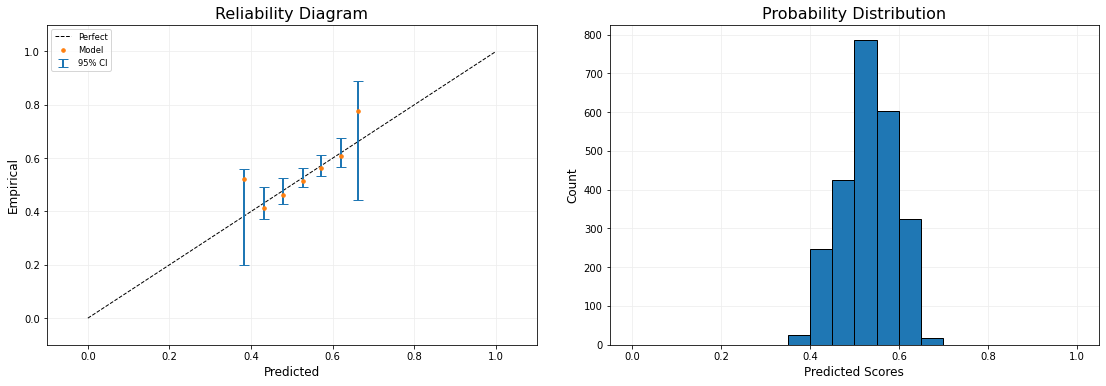

In [33]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_stb, show_histogram=True);

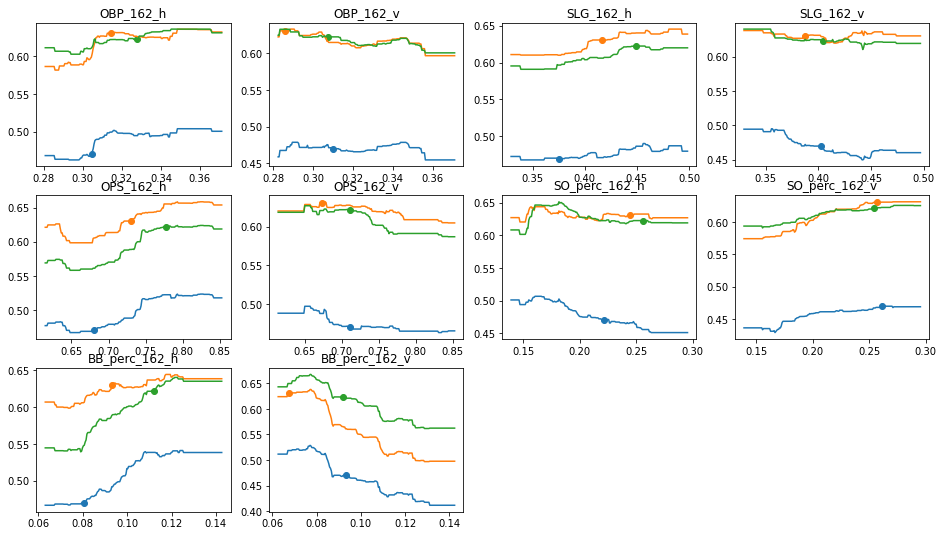

In [34]:
rd= mli.get_range_dict(X_train)
mli.ice_plot(stb1, plot_pts, X_test.columns, rd, plots_per_row=4)

- StructureBoost uniformly selects a random datapoint when there is no data at a given number, opposed to a harsh number set in LGightGBM
- This results in smoother lines in the ice plot 